# SVR Forecasting

<div style='text-align: justify;'>
The Support Vector Machine model is a neural network technique that can solve non-linear regression or classification problems. The aim of SVM, also denoted as support vector regression (SVR) in a regression problem, is to define a hyperplane that closely aligns with the given training dataset. At the same time, Support Vector Regression allows some margin for error.
The equations are consistent with the documentation of scikit-learn, which is a library in Python (Pedregosa et al., 2011).  
This specification of the SVR model uses similar covariates with the VAR model. The forecasting model for every market includes autoregressive lags for the selected index and for every global market up to lag order 10. The forecasting procedure is implemented using a rolling window with a size of 10 trading days. Even though the size of the window is arbitrary selected, it enables the parameters to be updated every 10 forecasts, which adds some extra non-linearly relationships. The training set consists of 90% of the full sample, and the testing set is 10%.
</div>

In [28]:
# Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [29]:
def import_data(path):
    # The data were downloaded from investment.com
    # Load Market index logarithmic returns
    df = pd.read_csv(path)

    # Change column name
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

    # Convert string to date time
    df['Date'] = pd.to_datetime(df['Date'])

    # Remove time
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')

    # Set frequency to avoid errors later in the VAR model
    df['Date'] = pd.DatetimeIndex(df['Date']).to_period('B')
    #df['Date'] = pd.DatetimeIndex(df['Date'])
    # Set Datetime index
    df.set_index('Date', inplace=True)
    return df

In [30]:
# Reutrns
path1="market_indexes_ret.csv"
market_return = import_data(path1)
market_indices_columns = market_return.columns.values

# Load market index prices
path2="market_indexes.csv"
market_price = import_data(path2)
market_indices_columns = market_price.columns.values

In [32]:
def var_svr(country, country_index, market_price, market_indices_columns):
    # The default values are testing_set: 10%, C:1
    # The value of epsilon was decided through grid selection with 10-fold cross validation


    # Estimate returns
    market_return = np.log(market_price) - np.log(market_price.shift(1))
    market_return.dropna(inplace=True)

    # Like an unrestricted VAR model
    # We create 3 lags for every market
    x = pd.DataFrame()
    for j in range(len(market_indices_columns)):
        # store the global market that is affecting the selected market
        global_market = market_indices_columns[j]

        lag_order = 10
        for lag in range(1,lag_order+1):
            name = "L" + str(lag) + global_market
            x[name] = market_return[global_market].shift(lag)


    x = x.dropna()
    end_train = int(len(x) * 0.90)

    # Set rolling window
    window = 10
    #end_test = market_return.shape[0]
    end_test = x.shape[0]
    y_forecast = pd.DataFrame()
    for i, start_test in enumerate(range(end_train, end_test, window)):
        # Split the data into training and testing samples
        if (end_test - start_test) >= window:
            start_train = i * window
            # We add the lagged values because for every market we assume that the prices are available at the same time
            x_train = x.iloc[start_train:start_test, :]
            x_test = x.iloc[start_test:(start_test + window), :]
            # The dependent variable is the return
            y_train = market_return.loc[x_train.index.values, country]  # Check this part
            y_actual = market_return.loc[x_test.index.values, country].to_frame()  # Check this part
        else:
            window2 = end_test - start_test
            start_train = i * window + window2
            # We add the lagged values because for every market we assume that the prices are available at the same time
            x_train = x.iloc[start_train:start_test, :]
            x_test = x.iloc[start_test:start_test + window2, :]
            # The dependent variable is the return
            y_train = market_return.loc[x_train.index.values, country]  # Check this part
            y_actual = market_return.loc[x_test.index.values, country].to_frame()  # Check this part

        # Set-Fit SVR
        # Tune the parameters in the SVR model with grid selection which is based on cross validation
        param = {'epsilon': [0.1, 0.01]},
        # param = {'C' : [1, 10, 50, 100 ], 'epsilon' : [1, 0.1, 0.01, 0.001] },
        grids = GridSearchCV(SVR(shrinking=False), param, scoring='neg_mean_squared_error', cv=10)

        RegrResults = grids.fit(x_train, y_train)

        best_epsilon = RegrResults.best_params_['epsilon']

        # Set-Fit SVR
        regr = make_pipeline(StandardScaler(), SVR(C=1, epsilon=best_epsilon))

        RegrResults = regr.fit(x_train, y_train)

        # Forecast
        y_forecast_temp = pd.DataFrame(data=regr.predict(x_test), index=y_actual.index, columns=[country])

        y_forecast = pd.concat([y_forecast, y_forecast_temp], ignore_index=False, sort=False)

    y_actual = pd.DataFrame(market_return.loc[y_forecast.index, country])

    y_forecast = pd.DataFrame(data=y_forecast.values, index=y_actual.index,
                                 columns=[country])

    initial_price = market_price.loc[y_actual.index.values[0], country]
    forecast_prices = initial_price * np.exp(y_forecast.cumsum())
    actual_prices = market_price.loc[y_actual.index.values, country]

    return (y_actual, y_forecast, actual_prices, forecast_prices)


In [33]:
y_actual = pd.DataFrame()
y_forecast = pd.DataFrame()
actual_prices = pd.DataFrame()
forecast_prices = pd.DataFrame()

for i,country in enumerate(market_indices_columns):
    #country_index = ordering[i]
    country_index = i
    y_actual[country], y_forecast[country], actual_prices[country], forecast_prices[country] = var_svr(country, country_index, market_price, market_indices_columns)

## Plot the results

In [37]:
# Convert them because otherwise matplotlib raise error because the dates are periods and not datetime
# Prices
market_price_index = market_price.index.to_timestamp(freq=None, how='start')
market_price = market_price.set_index([market_price_index])
forecast_prices_index = forecast_prices.index.to_timestamp(freq=None, how='start')
forecast_prices = forecast_prices.set_index([forecast_prices_index])

# Returns
market_return_index = market_return.index.to_timestamp(freq=None, how='start')
market_return = market_return.set_index([market_return_index])
y_forecast_index = y_forecast.index.to_timestamp(freq=None, how='start')
y_forecast = y_forecast.set_index([y_forecast_index])

y_actual_index = y_actual.index.to_timestamp(freq=None, how='start')
y_actual = y_actual.set_index([y_actual_index])

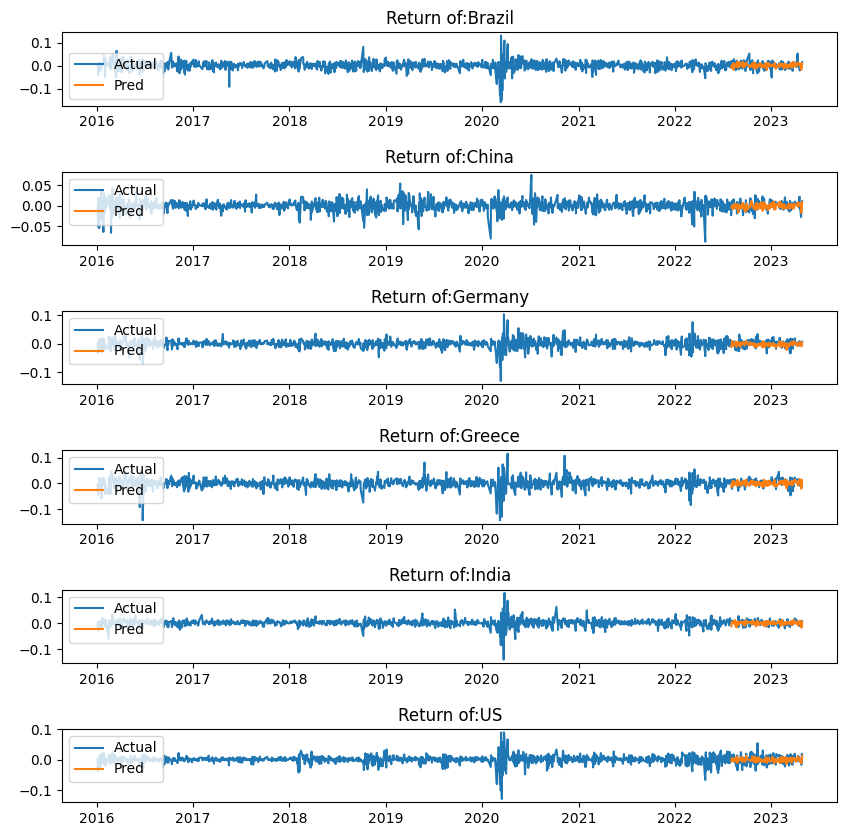

In [38]:
fig1, axes1 = plt.subplots(nrows=6,ncols=1,figsize=(10,10))
fig1.subplots_adjust(hspace=.9,wspace=0.4)
for i, ax1 in enumerate(axes1.flatten()):
    # Plot Returns
    ax1.set_title('Return of:' + market_indices_columns[i])

    sc11 = ax1.plot(market_return.iloc[:,i], label="Actual")
    sc12 = ax1.plot(y_forecast.iloc[:,i], label="Pred")
    sc1 = sc11 + sc12
    labs1 = [s.get_label() for s in sc1]
    ax1.legend(sc1, labs1)
plt.show()

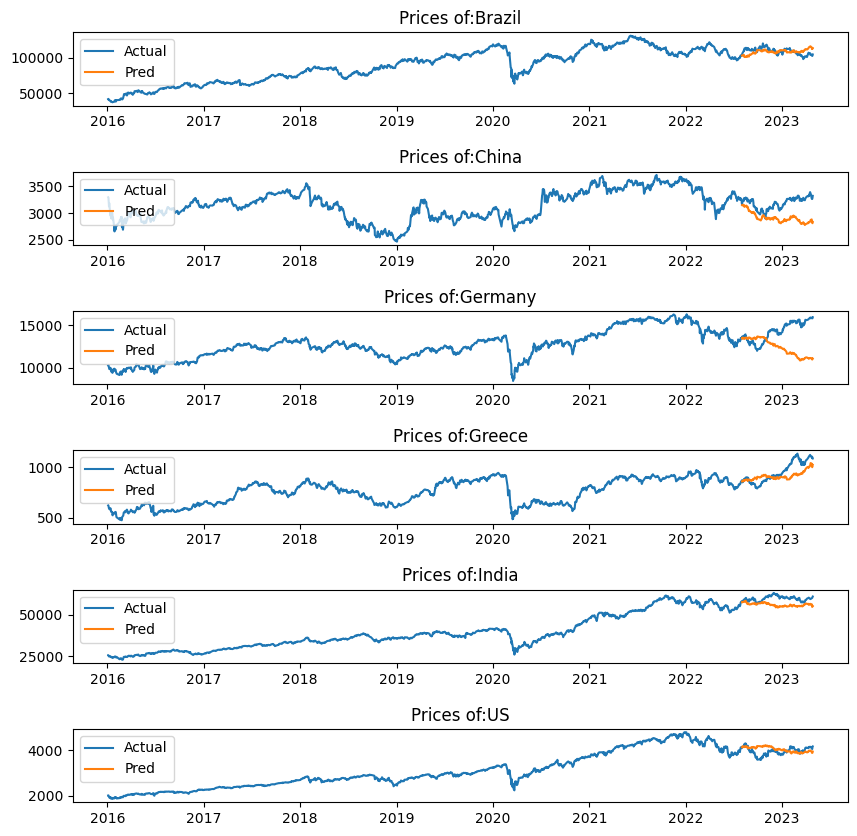

In [39]:
fig2, axes2 = plt.subplots(nrows=6,ncols=1,figsize=(10,10))
fig2.subplots_adjust(hspace=.9,wspace=0.4)
for i, ax2 in enumerate(axes2.flatten()):
    # Plot prices
    ax2.set_title("Prices of:" + market_indices_columns[i])

    sc21 = ax2.plot(market_price.iloc[:,i], label="Actual")
    sc22 = ax2.plot(forecast_prices.iloc[:,i], label="Pred")
    sc2 = sc21 + sc22
    labs2 = [s.get_label() for s in sc2]
    ax2.legend(sc2, labs2)
plt.show()

## Evaluation measures

In [40]:
def forecast_errors(actual, pred):
    # Make sure that actual and pred have the same size
    if actual.shape != pred.shape:
        raise IndexError("Actual and Pred matrix do not have the same size")
    fe = actual - pred
    return fe

In [41]:
# Mean square Error
def my_mse(actual, pred):
    f_errors = forecast_errors(actual, pred)
    mse = (f_errors ** 2).mean(0)
    return mse


# Root Mean Square Error (RMSE)
def my_rmse(actual, pred):
    mse = my_mse(actual, pred)
    rmse = mse ** 0.5
    return rmse


# Mean absolute error
def my_mae(actual, pred):
    f_errors = forecast_errors(actual, pred)
    mae = f_errors.abs().mean(0)
    return mae

In [42]:
def my_bcm(actual, pred):
    # Make sure that actual and pred have the same size
    if actual.shape != pred.shape:
        raise IndexError("Actual and Pred matrix do not have the same size")

    # When the return is positive it becomes True otherwise False
    binary_actual=actual > 0
    binary_pred = pred > 0

    bcm = pd.DataFrame(0, index=['Pred_Pos', 'Pred_Neg'], columns=['Act_Neg', 'Act_Pos'])

    for row in range(actual.shape[0]):
        if (binary_actual.iloc[row] == True) and (binary_pred.iloc[row] == True):
            bcm.iloc[0, 1] += 1

        elif (binary_actual.iloc[row] == True) and (binary_pred.iloc[row] == False):
            bcm.iloc[1, 1] += 1

        elif (binary_actual.iloc[row] == False) and (binary_pred.iloc[row] == True):
            bcm.iloc[0, 0] += 1

        elif (binary_actual.iloc[row] == False) and (binary_pred.iloc[row] == False):
            bcm.iloc[1, 0] += 1
    return bcm


def my_mult_bcm(actual, pred):
    """
    Estimates the binary confusion matrix for every market
    """
    # Make sure that actual and pred have the same size
    if actual.shape != pred.shape:
        raise IndexError("Actual and Pred matrix do not have the same size")

    mbcm = []
    for col in range(actual.shape[1]):
        bcm = my_bcm(actual.iloc[:,col], pred.iloc[:,col])
        mbcm.append(bcm)
    return mbcm

In [43]:
# Precision
def my_precision(actual, pred):
    mbcm = my_mult_bcm(actual, pred)
    precision=pd.DataFrame(0, index=actual.columns, columns=['Precision'])
    for i in range(len(mbcm)):
        bsm = mbcm[i]
        precision.iloc[i,0] = (bsm.iloc[0,1]/(bsm.iloc[0,1]+bsm.iloc[0,0]))
    return precision


# Recall
def my_recall(actual, pred):
    mbcm = my_mult_bcm(actual, pred)
    recall = pd.DataFrame(0, index=actual.columns, columns=['Recall'])
    for i in range(len(mbcm)):
        bsm = mbcm[i]
        recall.iloc[i,0] = (bsm.iloc[0,1]/(bsm.iloc[0,1]+bsm.iloc[1,1]))
    return recall


# F1 Score
def my_f1(actual, pred):
    f1 = pd.DataFrame(0, index=actual.columns, columns=['F1_score'])
    precision = my_precision(actual, pred)
    recall = my_recall(actual, pred)
    for i in range(len(actual.columns)):
        f1.iloc[i,0] = 2*((precision.iloc[i,0]*recall.iloc[i,0])/(precision.iloc[i,0]+recall.iloc[i,0]))
    return f1

In [44]:
def my_eval_meas(actual, pred):
    eval_meas=pd.DataFrame(0, index= actual.columns, columns=['MSE', 'RMSE', 'MAE', 'Precision', 'Recall', 'F1_Score'])
    eval_meas['MSE'] = my_mse(actual, pred)
    eval_meas['RMSE'] = my_rmse(actual, pred)
    eval_meas['MAE'] = my_mae(actual, pred)


    eval_meas['Precision'] = my_precision(actual, pred)
    eval_meas['Recall'] = my_recall(actual, pred)
    eval_meas['F1_Score'] = my_f1(actual, pred)
    return eval_meas

In [52]:
EVAL = my_eval_meas(y_actual, y_forecast)
EVAL.head(6)

,MSE,RMSE,MAE,Precision,Recall,F1_Score
Brazil,0.000267,0.016327,0.013095,0.532468,0.518987,0.525641
China,0.000117,0.010804,0.008058,0.561644,0.561644,0.561644
Germany,0.000158,0.012556,0.009582,0.671875,0.462366,0.547771
Greece,0.000195,0.013960,0.010719,0.597561,0.556818,0.576471
India,0.000077,0.008765,0.006896,0.693333,0.611765,0.650000
US,0.000178,0.013339,0.010633,0.550725,0.527778,0.539007
